In [180]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from numpy import ndarray as Array
from typing import Any, Dict, List, Tuple
from matplotlib import pyplot as plt
DATASETS_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Datasets'))
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [181]:
from sklearn.model_selection import train_test_split

class ShapData:
    """Data class for images where xp-space is the superpixel space for the images"""
    def __init__(self,
                 dataset_name:str,
                 drop_cols:List[str]=None,
                 feature_labels:List[str]=None,
                 target_label:str=None,
                 test_size:float=0.2):

        dataset_file = os.path.join(DATASETS_PATH, f'{dataset_name}.csv')
        dataset = pd.read_csv(dataset_file)
        print('Sample of the Raw Dataset')
        print(dataset.head())
        if drop_cols is not None:
            dataset.drop(columns=drop_cols, axis=1, inplace=True)
        print()
        print('Sample of the Cleaned Dataset')
        print(dataset.head())

        self.ref_data, self.test_data = self.split_dataset(dataset,
                                                           test_size=test_size)
        print()
        print(f'N Train Datapoints: {len(self.ref_data)}, '
              f'N Test Datapoints: {len(self.test_data)}, '
              f'N Features: {len(self.ref_data.columns) - 1}')
        self.n_train, self.n_test = len(self.ref_data), len(self.test_data)
        self.features = list(dataset.columns)[:-1]
        self.target = list(dataset.columns)[-1]
        self.n_features = len(self.features)
        self.feature_labels = self.features if feature_labels is None else feature_labels
        self.target_label = self.target if target_label is None else target_label

    @property
    def dim(self):
        return self.n_features

    def split_dataset(self,
                      dataset:DF,
                      test_size:float=0.2) -> Tuple[DF, DF]:
        return train_test_split(dataset, test_size=test_size)

    def get_data_sample(self,
                        subset:str,
                        sample_size:int=None) -> DF:

        data = self.ref_data if subset == 'ref' else self.test_data
        samples, targets = data[self.features].to_numpy(), data[self.target].to_numpy()
        if sample_size is not None:
            n = samples.shape[0]
            samples_idxs = np.random.choice(np.arange(n), size=sample_size, replace=False)
            samples, targets = samples[samples_idxs], targets[samples_idxs]
        return samples, targets

In [182]:
from math import prod

class ShapModel:
    def __init__(self,
                 model):
        self.model = model

    def predict(self,
                datapoints:Array) -> Array:
        # Flatten the feature array into 2d array --- the feature dimension remains as is
        flat_size = prod(datapoints.shape[:-1])
        return self.model.predict(datapoints.reshape(flat_size, -1)).reshape(*datapoints.shape[:-1])
    
    def train_and_test(self,
                       train_data:Array,
                       train_target:Array,
                       test_data:Array,
                       test_target:Array):

        self.model.fit(train_data, train_target)
        return self.model.score(test_data, test_target)

In [ ]:
import math

class Shap:
    def __init__(self,
                 ref_data:Array,
                 model:ShapModel,
                 n_perms:int=10):
        self.ref_data = ref_data
        self.model = model
        self.n_perms = n_perms
        self.n_perms2 = (2 * self.n_perms)
        self.n_features = self.ref_data.shape[1]
        self.n_ref = self.ref_data.shape[0]

    def n_samples(self, n_examples:int): return (n_examples * self.n_perms)

    def generate_coalition_masks(self, n_examples:int):
        """Generate the masks used to apply permutations to the features
        - n_perms permutations for each sample and the masks correspond to 
        both the l2r and r2l coalitions for every feature"""
        nsamples = self.n_samples(n_examples)
        def restore_perm_and_reshape(a:Array):
            a = np.take_along_axis(a, revs, axis=1)
            return np.reshape(a, (n_examples, self.n_perms,
                                  self.n_features, self.n_features))

        # Generate 'n_sample' permutations of the features
        idxs = np.tile(np.array([[i for i in np.arange(self.n_features)]]), 
                       (nsamples, 1))
        rng = np.random.default_rng()
        perms = rng.permuted(idxs, axis=1)

        # Get the inverses of the permutations and  expand it in the feature dimension (dim 2)
        # so the same position permutations are applied to each sample-feature pair
        rev = np.argsort(perms, axis=1)
        assert np.all(idxs == np.take_along_axis(perms, rev, axis=1))
        revs = np.tile(rev[:,:,np.newaxis], (1, 1, self.n_features))

        # perm_mask[i,j,k] will be 1 iff in the i-th permutation (sample),
        # feature k appears in position j. It's a 0-1 array
        # dim 1 of size self.n_features represents features
        # dim 2 of size self.n_features represents a coalition in which the feature can appear
        perm_mask = np.eye(self.n_features)[perms]
        assert perm_mask.shape == (nsamples, self.n_features, self.n_features), \
                f'{perm_mask.shape} != {(nsamples, self.n_features, self.n_features)}'

        # The 1's in each of the 4 arrays below represent possible coalitions for each 
        # sample-feature pair
        # incl - including the feature in the coalition; excl - excluding the feature
        # l2r - the coalition of features following any given feature in the permutation
        # r2l - the coalition of features preceding the feature
        l2r_incl = np.cumsum(perm_mask, axis=1)
        # Subtract perm_mask to set the perm_mask locations back to zero
        l2r_excl = l2r_incl - perm_mask
        # Revert back to the original order of the features and reshape them
        l2r_incl = restore_perm_and_reshape(l2r_incl)
        l2r_excl = restore_perm_and_reshape(l2r_excl)
        # Create the r2l coalitions
        r2l_incl, r2l_excl = (1 - l2r_excl), (1 - l2r_incl)

        # The r2l and l2r coalitions together gives us double the number of samples
        # for each datapoint-feature pair
        incl_mask = np.concatenate([l2r_incl, r2l_incl], axis=1)
        excl_mask = np.concatenate([l2r_excl, r2l_excl], axis=1)
        assert (incl_mask.shape == excl_mask.shape ==
                (n_examples, self.n_perms2,
                 self.n_features, self.n_features))

        # Finding the shap weights --- depending on the coalition size (count)
        # Higher the coalition size the higher the weight
        weights = 1.0 / (self.n_features - np.sum(excl_mask, axis=3, dtype=int))
        assert (weights.shape == (n_examples, self.n_perms2, self.n_features))
        return incl_mask, excl_mask, weights

    def generate_coalition_samples(self, expl_data:Array, mean_ref_data:Array):
        """Generate coalitions of features and random 'reference' samples
        for each datapoint in 'expl_data'. Use the coalition mask to fill
        values of features not in the coalition with values from the mean_ref_data.
        For each feature, we need samples that include the original feature value
        and samples that exclude the original feature value (replaced by the reference value).
        The coalitions are generated using the permutation method
        """
        n_examples = expl_data.shape[0]
        x = np.expand_dims(expl_data, axis=(1, 2))
 
        # Generate the coalition masks
        incl_mask, excl_mask, weights = self.generate_coalition_masks(n_examples)
        # Apply the coalition masks (of the features) to x and the random samples
        # The 'reference' values for the features outside the coalition come from the 
        # random samples and for those in the coalition come from xx
        mean_ref_data = np.expand_dims(mean_ref_data, axis=(1, 2))
        shap_samples_incl = np.where(incl_mask == 1, x, mean_ref_data)
        shap_samples_excl = np.where(excl_mask == 1, x, mean_ref_data)
        return shap_samples_incl, shap_samples_excl, weights

    def shap(self,
             explanation_samples:Array,
             sort_for_each_datapoint:bool):
        """Core Shap algorithm --- will return the shapley values of the features 
        for each datapoint in 'explanation_samples'"""
        n_examples = explanation_samples.shape[0]
        # Reference data is the mean of the training data --- used for 'reference'
        mean_ref_data = np.mean(self.ref_data, axis=0, keepdims=True)
        samples_incl, samples_excl, weights = \
            self.generate_coalition_samples(explanation_samples, mean_ref_data)

        # Carry out the predictions
        incl_preds = self.model.predict(samples_incl)
        excl_preds = self.model.predict(samples_excl)
        sample_preds = self.model.predict(explanation_samples)
        ref_pred = self.model.predict(mean_ref_data)

        deltas = (incl_preds - excl_preds)
        assert deltas.shape == (n_examples, self.n_perms2, self.n_features), \
            f'Expected shape: {(n_examples, self.n_perms2, self.n_features)}, got: {deltas.shape}'

        # Consistency Check --- for 'Local accuracy' or the Shapely efficiency property
        total_contributions = np.sum(np.mean(deltas, axis=1), axis=1)
        contribution_mse = np.mean((total_contributions - sample_preds + ref_pred)**2)
        print(f'Total Contribution vs Prediction MSE: {contribution_mse:0.3f}')

        # Compute the Shapley values --- one can do this with or without the weights
        shap_values = np.mean(deltas, axis=1)
        # shap_values = np.mean(deltas * weights, axis=1)

        if sort_for_each_datapoint:
            # Sort features by Shapley value for each datapoint
            sorted_feature_indices = np.argsort(shap_values, axis=1)
            sorted_shap_values = np.take_along_axis(shap_values, 
                                                    sorted_feature_indices, axis=1)
            return sorted_feature_indices.tolist(), sorted_shap_values.tolist()
        else:
            return shap_values

    def local_shap(self,
                   expl_data:Array,
                   expl_targets:Array,
                   feature_labels:List[str],
                   all_features:List[str]):
        feature_idxs, shap_values = self.shap(expl_data,
                                              sort_for_each_datapoint=True)
        features = [[feature_labels[i] for i in l] for l in feature_idxs]
        for i in range(len(features)):
            print()
            datapoint = pd.DataFrame(np.concatenate([expl_data[i].reshape(1, -1),
                                                    expl_targets[i].reshape(1, -1)],
                                                    axis=1),
                                    columns=(all_features + ['Count']))
            self.local_plot(datapoint, features[i], shap_values[i])

    def shap_dependence_plots(self,
                              dataset:Array,
                              shap_values:Array,
                              importance_idxs:List[int],
                              feature_labels:List[str],):
        fig, ax = plt.subplots(2, 2, figsize=(20, 6))
        for i, idx in enumerate(importance_idxs[-4:]):
            x, y = dataset[:, idx], shap_values[:, idx]
            ax[i//2, i%2].scatter(x, y, s=5)
            ax[i//2, i%2].set_xlabel(f'{feature_labels[idx]} Value')
            ax[i//2, i%2].set_ylabel(f'Shapley Value for {feature_labels[idx]}')

        plt.show()

        
    def global_shap(self,
                    dataset:Array,
                    feature_labels:List[str],
                    bucket_size:float):
        vspread_delta, gap_between_features = 0.05, 10
        """Compute the global Shapley values for the features in 'dataset'"""
        def y_coord(feature_indx:int, datapoint_idx:int, feature_val:float):
            n_in_bucket = len(buckets[feature_val])
            pos_in_bucket = buckets[feature_val].index(datapoint_idx)
            return ((gap_between_features * (feature_indx + 1)) - 
                    (n_in_bucket/2)*vspread_delta + 
                    (pos_in_bucket*vspread_delta))

        def color(val:float, Mx:float, mn:float):
            mid = (Mx + mn)/2
            r = 0 if val < mid else (val - mid)/(Mx - mid)
            b = 0 if val > mid else (mid - val)/(mid - mn)
            return (r, 0, b)

        shap_values = self.shap(dataset, sort_for_each_datapoint=False)
        print(shap_values.shape)
        print()
        for i, label in enumerate(feature_labels):
            print(f'Feature: {label} ----- '\
                  f'Shap Values Max: {np.max(shap_values[:, i])}, '\
                  f'Min: {np.min(shap_values[:,i])}')
        mean_feature_shap = np.mean(np.abs(shap_values), axis=0)
        importance_idxs = np.argsort(mean_feature_shap).tolist()
        labels = [feature_labels[i] for i in importance_idxs]
        plot_points = []
        for j, idx in enumerate(importance_idxs):
            M, m = np.max(dataset[:, idx]), np.min(dataset[:, idx])
            feature_values = dataset[:, idx]
            feature_shap_values = [(math.floor(v/bucket_size)*bucket_size)
                                    for v in shap_values[:, idx].tolist()]
            buckets = {}
            for i, v in enumerate(feature_shap_values):
                if v not in buckets:
                    buckets[v] = []
                buckets[v].append(i)
            plot_points.extend([(v, y_coord(j, i, v),
                                 color(feature_values[i], M, m))
                                for i, v in enumerate(feature_shap_values)])
        x, y, c = zip(*plot_points)
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.tick_params(axis='y', pad=10)
        plt.subplots_adjust(left=0.3)
        ax.scatter(x, y, s=5, c=c)
        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)
        ax.set_yticks([(gap_between_features * (i + 1)) for i in range(len(labels))])
        ax.set_yticklabels(labels, ha='left')
        ax.tick_params(axis='y', labelsize='small')
        ax.set_xlabel('Shap Value')
        plt.show()

        self.shap_dependence_plots(dataset, shap_values, importance_idxs,
                                   feature_labels)

    def local_plot(self,
                  datapoint:DF,
                  features:List[str],
                  shap_values:List[float]):
        """Plot the explanation for the decision 'decision_label for the ith test datapoint
        label_value_strengths: is the list of tuples of (feature_label, feature_value and feature_strength), 'feature_strength' being the contribution of that feature to the
        decision.
        """
        print(f'Shap Values Plot for the datapoint:')
        print(datapoint)
        print()
        fig, ax = plt.subplots()
        bar_colors = [('red' if s < 0 else 'green') for s in shap_values]
        label_values = [f'{l} ({v:.3F})' for l, v in list(zip(features, shap_values))]
        y_pos = np.arange(len(features))
        ax.barh(y_pos, shap_values, align='center', color=bar_colors)
        ax.set_yticks(y_pos, labels=label_values)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Feature Shap')
        ax.set_ylabel('Feature - Value')
        ax.set_title('Shap Feature Importance')
        plt.show()

Sample of the Raw Dataset
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  weathersit    temp   atemp     hum  windspeed  casual  registered   cnt
0        1  2011-01-01       1   0     1        0        6           0           2 0.34417 0.36362 0.80583    0.16045     331         654   985
1        2  2011-01-02       1   0     1        0        0           0           2 0.36348 0.35374 0.69609    0.24854     131         670   801
2        3  2011-01-03       1   0     1        0        1           1           1 0.19636 0.18940 0.43727    0.24831     120        1229  1349
3        4  2011-01-04       1   0     1        0        2           1           1 0.20000 0.21212 0.59044    0.16030     108        1454  1562
4        5  2011-01-05       1   0     1        0        3           1           1 0.22696 0.22927 0.43696    0.18690      82        1518  1600

Sample of the Cleaned Dataset
   season  mnth  holiday  weekday  workingday  weathersit    temp     hum  wind

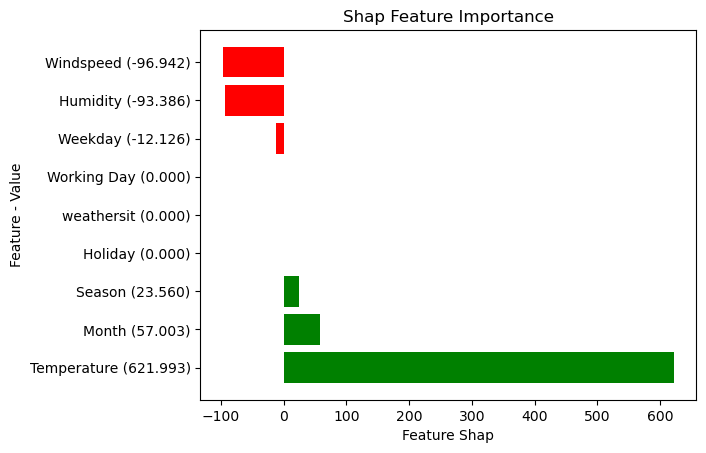


Shap Values Plot for the datapoint:
   season    mnth  holiday  weekday  workingday  weathersit    temp     hum  windspeed      Count
0 2.00000 3.00000  0.00000  2.00000     1.00000     1.00000 0.44167 0.62458    0.22575 2703.00000



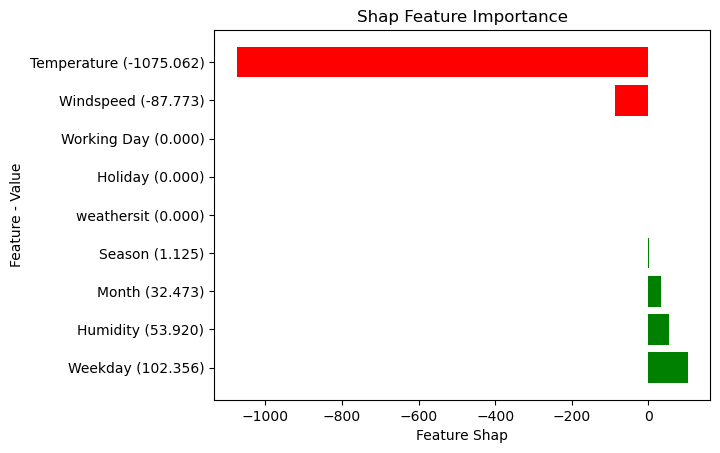


Shap Values Plot for the datapoint:
   season    mnth  holiday  weekday  workingday  weathersit    temp     hum  windspeed      Count
0 2.00000 4.00000  0.00000  1.00000     1.00000     2.00000 0.59565 0.71696    0.32447 3348.00000



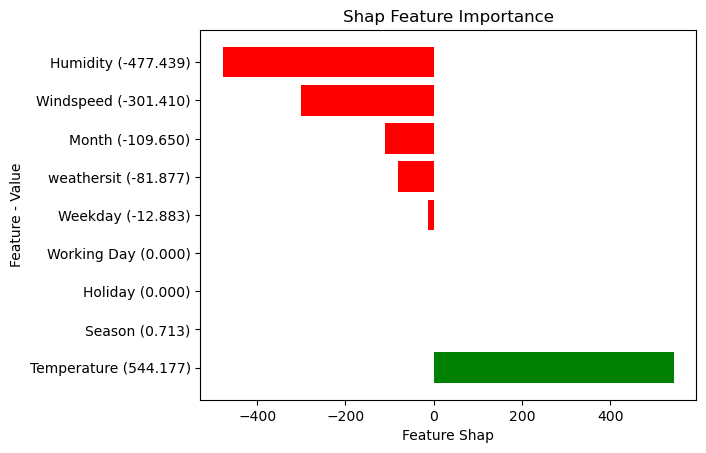


Shap Values Plot for the datapoint:
   season    mnth  holiday  weekday  workingday  weathersit    temp     hum  windspeed      Count
0 1.00000 3.00000  0.00000  5.00000     1.00000     1.00000 0.54000 0.52522    0.23102 3239.00000



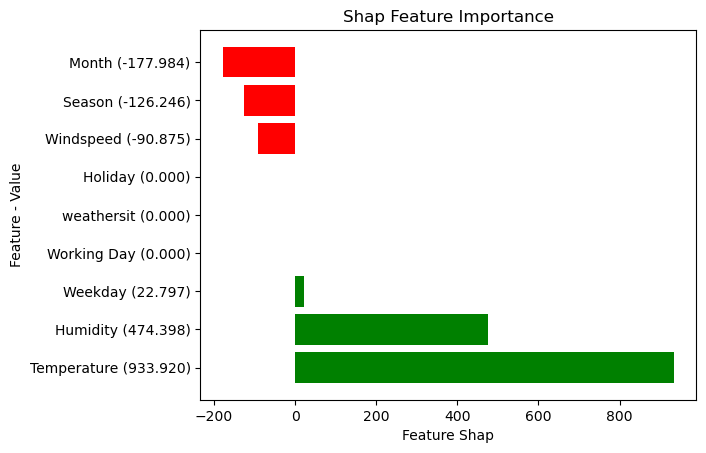


Shap Values Plot for the datapoint:
   season    mnth  holiday  weekday  workingday  weathersit    temp     hum  windspeed      Count
0 2.00000 5.00000  0.00000  1.00000     1.00000     2.00000 0.63167 0.81000    0.23384 4274.00000



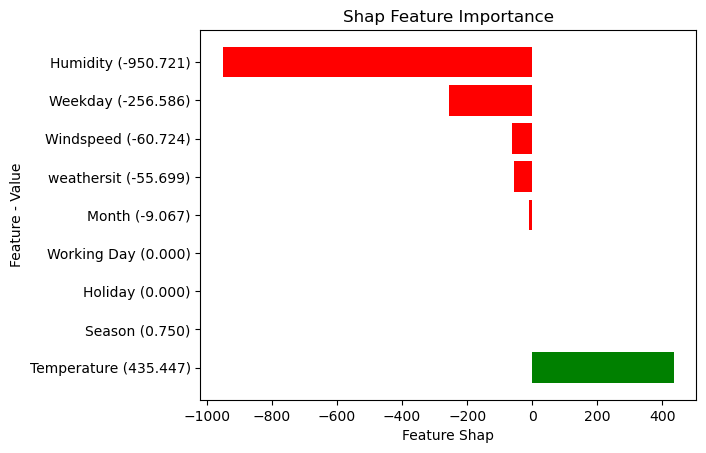

Total Contribution vs Prediction MSE: 0.000
(584, 9)

Feature: Season ----- Shap Values Max: 1071.9945000000005, Min: -527.0761666666666
Feature: Month ----- Shap Values Max: 692.2383333333338, Min: -740.5673333333335
Feature: Holiday ----- Shap Values Max: 113.20783333333333, Min: -570.1550000000002
Feature: Weekday ----- Shap Values Max: 708.0233333333332, Min: -554.2675000000002
Feature: Working Day ----- Shap Values Max: 166.5783333333333, Min: -231.5611666666665
Feature: weathersit ----- Shap Values Max: 59.69233333333349, Min: -742.2945000000001
Feature: Temperature ----- Shap Values Max: 1502.6405000000004, Min: -3854.2405000000003
Feature: Humidity ----- Shap Values Max: 1284.2406666666668, Min: -3339.490500000001
Feature: Windspeed ----- Shap Values Max: 1005.2096666666671, Min: -1102.6939999999997


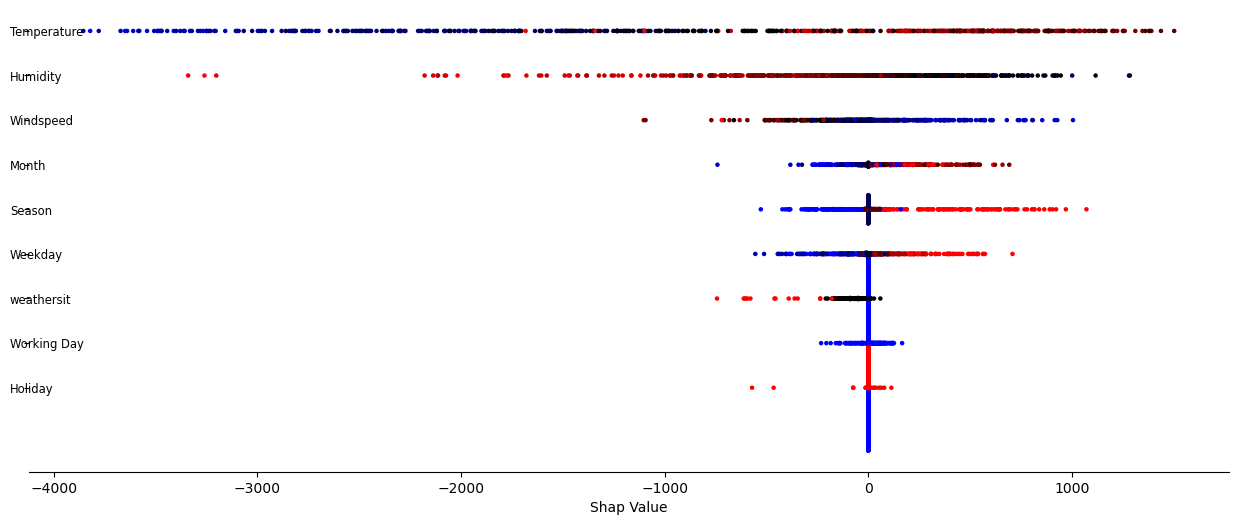

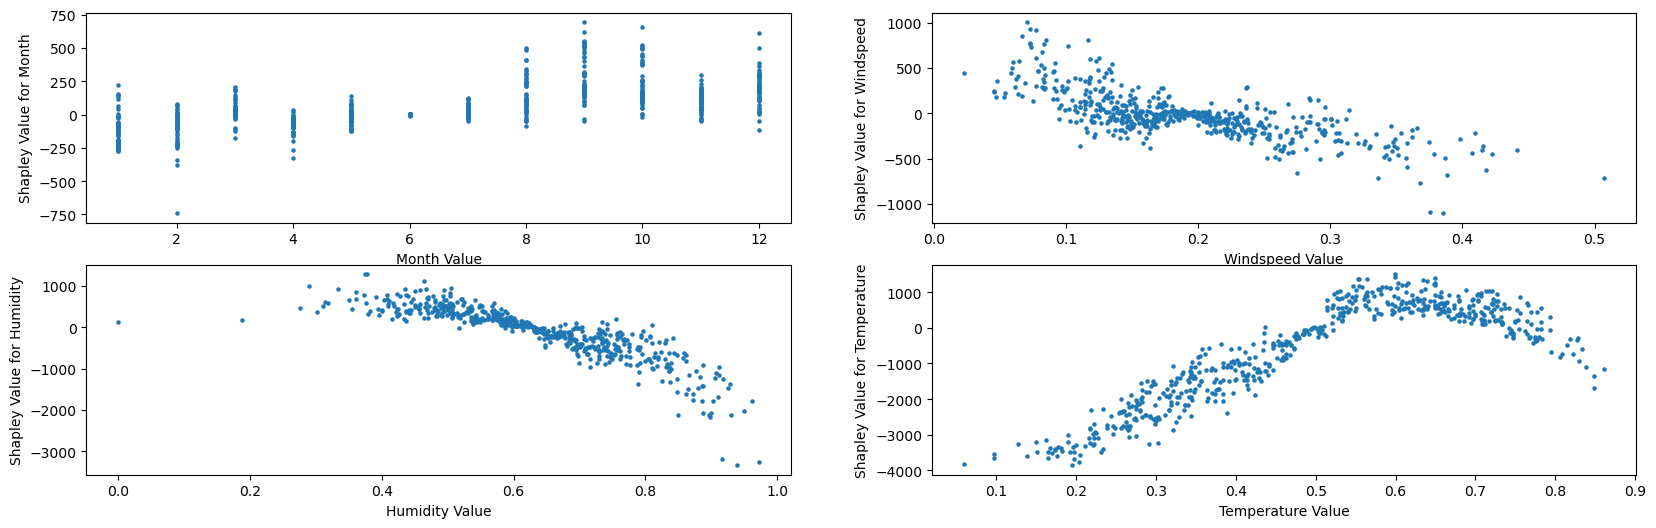

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

N_EXPLANATION_SAMPLES = 5
N_PERMS = 30
BUCKET_SIZE = 1.0

shap_data = ShapData('bikesharing_daily',
                     drop_cols=['yr', 'instant','dteday','casual','registered', 'atemp'],
                     feature_labels=['Season', 'Month', 'Holiday', 'Weekday',
                                     'Working Day', 'weathersit', 'Temperature', 'Humidity',
                                     'Windspeed'],
                     target_label='Count')
ref_data, ref_targets = shap_data.get_data_sample(subset='ref')
expl_data, expl_targets = shap_data.get_data_sample(subset='test',
                                                    sample_size=N_EXPLANATION_SAMPLES)
shap_model = ShapModel(model=RandomForestRegressor())
print()
test_score = shap_model.train_and_test(ref_data, ref_targets,
                                       expl_data, expl_targets)

print()
print('Trained the Model on the Training Data. Test Score: ', test_score)

shap = Shap(ref_data=ref_data,
            model=shap_model,
            n_perms=N_PERMS)
shap.local_shap(expl_data, expl_targets, shap_data.feature_labels, shap_data.features)

shap.global_shap(ref_data, shap_data.feature_labels, bucket_size=BUCKET_SIZE)
